In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import coco
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco_humanpose.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
COCO_DIR = "/home/xiaowu/Documents/Mask_RCNN_Humanpose-master/images"  # TODO: enter you own value here

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    USE_MINI_MASK = True
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="training", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = COCO_MODEL_PATH
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

Loading weights from  /home/xiaowu/Documents/Mask_RCNN_Humanpose-master/mask_rcnn_coco_humanpose.h5


loading annotations into memory...
Done (t=8.00s)
creating index...
index created!
Skeleton: (19, 2)
Keypoint names: (17,)
Train Keypoints Image Count: 64115
Train Keypoints Class Count: 2
  0. BG                                                
  1. person                                            
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max: 48252.00000
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (2, 4)                min:    1.00000  max:  221.00000
gt_mask                  shape: (56, 56, 2)           min:    0.00000  max:    1.00000
gt_keypoint              shape: (2, 17, 3)            min:    0.00000  max:  221.00000
keypoint_shape: (2, 17, 3)


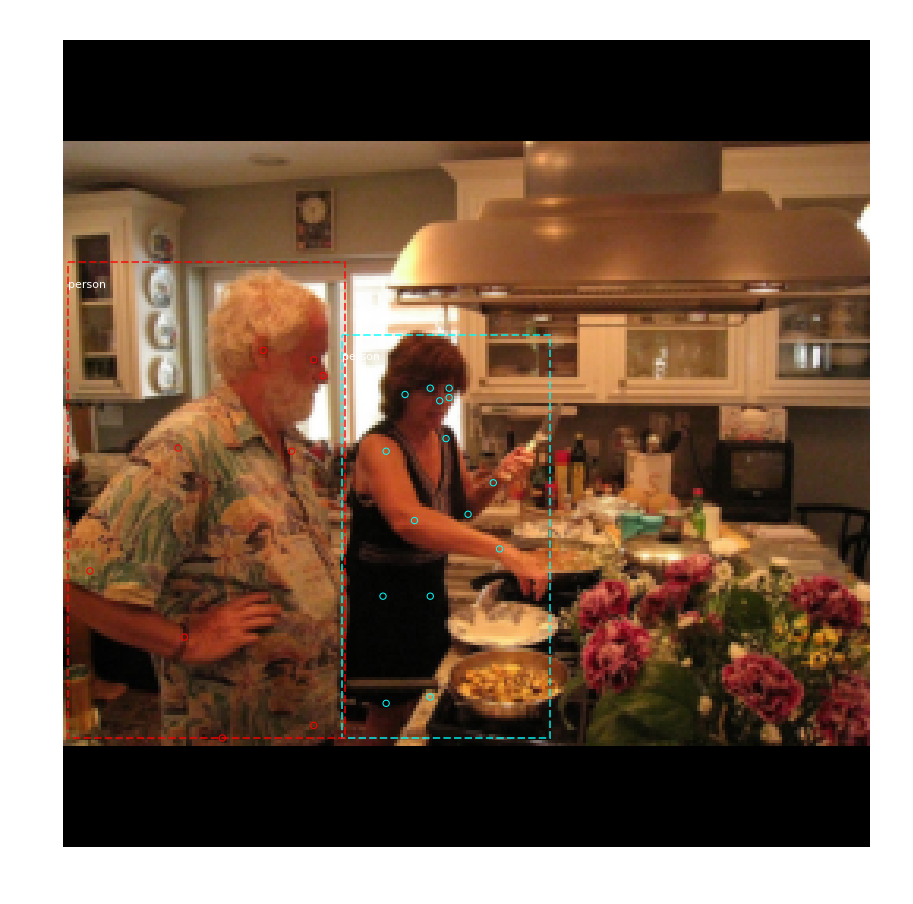

TypeError: compute_ap() missing 4 required positional arguments: 'pred_boxes', 'pred_class_ids', 'pred_scores', and 'pred_masks'

In [9]:
# Load dataset
assert config.NAME == "coco"
# Training dataset
#load person keypoints dataset
train_dataset_keypoints = coco.CocoDataset(task_type="person_keypoints")
train_dataset_keypoints.load_coco(COCO_DIR, "train")
train_dataset_keypoints.prepare() 
print("Train Keypoints Image Count: {}".format(len(train_dataset_keypoints.image_ids)))
print("Train Keypoints Class Count: {}".format(train_dataset_keypoints.num_classes))
for i, info in enumerate(train_dataset_keypoints.class_info):
    print("{:3}. {:50}".format(i, info['name']))

image_id = random.choice(train_dataset_keypoints.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_keypoint =\
    modellib.load_image_gt_keypoints(train_dataset_keypoints, config, 
                           image_id, augment=False,use_mini_mask=config.USE_MINI_MASK)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
log("gt_keypoint", gt_keypoint)

visualize.display_keypoints(original_image,gt_bbox,gt_keypoint,gt_class_id,train_dataset_keypoints.class_names)

## 1.1 Inspect the flipping augument

In [ ]:
# Test on a random image
image_id = random.choice(train_dataset_keypoints.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_keypoint =\
    modellib.load_image_gt_keypoints(train_dataset_keypoints, config, 
                           image_id, augment=False,use_mini_mask=config.USE_MINI_MASK)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
log("gt_keypoint", gt_keypoint)

visualize.display_keypoints(original_image,gt_bbox,gt_keypoint,gt_class_id,train_dataset_keypoints.class_names)
if(config.USE_MINI_MASK):
    gt_mask = utils.expand_mask(gt_bbox,gt_mask,original_image.shape)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_dataset_keypoints.class_names,)

original_image_flip, image_meta_flip, gt_class_id_flip, gt_bbox_flip, gt_mask_flip, gt_keypoint_flip =\
    modellib.load_image_gt_keypoints(train_dataset_keypoints, config, 
                           image_id, augment=True,use_mini_mask=config.USE_MINI_MASK)


visualize.display_keypoints(original_image_flip,gt_bbox_flip,gt_keypoint_flip,gt_class_id_flip,train_dataset_keypoints.class_names)
if(config.USE_MINI_MASK):
    gt_mask_flip = utils.expand_mask(gt_bbox_flip,gt_mask_flip,original_image_flip.shape)
visualize.display_instances(original_image_flip, gt_bbox_flip, gt_mask_flip, gt_class_id_flip, 
                            train_dataset_keypoints.class_names,)


## 1.2 Inspect the DetectionKeypointTargetLayer
This layers generated the ground truth keypoint labels and their values are between[0, 56*56).
Here we run a sub graph to generated the ground truth target and visulize them to check it.

In [ ]:

# rois, target_class_ids, target_bbox, target_keypoint, target_keypoint_weight, target_mask
train_keypoint_generator = modellib.data_generator_keypoint(train_dataset_keypoints, config, shuffle=True,
                                         batch_size=config.BATCH_SIZE)

#python 3.* use nexy(generator)
inputs,_ = next(train_keypoint_generator)
batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox, batch_gt_class_ids, \
            batch_gt_boxes, batch_gt_keypoints,batch_gt_masks  = inputs
log("batch_images",batch_images)
log("batch_image_meta",batch_image_meta)
log("batch_rpn_match",batch_rpn_match)
log("batch_rpn_bbox",batch_rpn_bbox)
log("batch_gt_class_ids",batch_gt_class_ids)
log("batch_gt_boxes",batch_gt_boxes)
log("batch_gt_keypoints",batch_gt_keypoints)
log("batch_gt_masks",batch_gt_masks)

rpn = model.run_graph(inputs, [
    ("rois", model.keras_model.get_layer("proposal_targets").output[0]),
    ("target_class_ids", model.keras_model.get_layer("proposal_targets").output[1]),
    ("target_bbox", model.keras_model.get_layer("proposal_targets").output[2]),
    ("target_keypoint_lables", model.keras_model.get_layer("proposal_targets").output[3]),
    ("target_keypoint_weights", model.keras_model.get_layer("proposal_targets").output[4]),
    ("target_mask", model.keras_model.get_layer("proposal_targets").output[5]),
])

roi = rpn["rois"]
target_class_ids = rpn["target_class_ids"]
target_bbox = rpn["target_bbox"]
target_keypoint_label = rpn["target_keypoint_lables"]
target_keypoint_weight = rpn["target_keypoint_weights"]
target_mask = rpn["target_mask"]
# gt_keypoints = rpn["gt_keypoints"]
keypoint_scales = [config.IMAGE_SHAPE[1],config.IMAGE_SHAPE[0],1]
# gt_keypoints = keypoint_scales*gt_keypoints
log("real")
for i in range(config.BATCH_SIZE):
    batch_orignal_image = modellib.unmold_image(batch_images[i],config)
    visualize.display_image_keypoint_mask(batch_orignal_image,roi[i],target_keypoint_label[i],target_keypoint_weight[i],
                                          target_class_ids[i],train_dataset_keypoints.class_names,config=config,iskeypointlabel= True)



## 1.3 Inspect some layers in build_fpn_keypoint_graph

In [ ]:
rpn = model.run_graph(inputs, [
    ("mrcnn_keypoint_mask_upsample_1", model.keras_model.get_layer("mrcnn_keypoint_mask_upsample_1").output),
    ("mrcnn_keypoint_mask_transpose", model.keras_model.get_layer("mrcnn_keypoint_mask_transpose").output),
    ("mrcnn_keypoint_mask_reshape", model.keras_model.get_layer("mrcnn_keypoint_mask_reshape").output),
])
plot.imshow(rpn["mrcnn_keypoint_mask_reshape"])

## 1.4 Inspect the inner value of keypoint_mrcnn_mask_loss_graph
    Before you run this cell, you must uncomment the "test_mrcnn_mask_loss_graph" in the model.py(Line 2726-2727) and add it in the output list.

In [ ]:
rpn = model.run_graph(inputs, [
    ("pred_keypoint", model.keras_model.get_layer("pred_keypoint").output),
    ("target_keypoint", model.keras_model.get_layer("target_keypoint").output),
    ("target_class_ids_reshape", model.keras_model.get_layer("target_class_ids_reshape").output),
    
    ("pred_keypoint_reshape", model.keras_model.get_layer("pred_keypoint_reshape").output),
    ("target_keypoint_reshape", model.keras_model.get_layer("target_keypoint_reshape").output),
    ("positive_pred_keypoint_masks", model.keras_model.get_layer("positive_pred_keypoint_masks").output),
    ("positive_target_keypoints", model.keras_model.get_layer("positive_target_keypoints").output),
    ("soft_loss", model.keras_model.get_layer("soft_loss").output),
    ("positive_loss", model.keras_model.get_layer("positive_loss").output),
    ("num_valid", model.keras_model.get_layer("num_valid").output),
    ("keypoint_loss", model.keras_model.get_layer("keypoint_loss").output),
])